In [2]:
import pickle
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import torch
from torch.utils.data import Dataset
from skimage import io
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pickle
import time
import torch.optim as optim
import seaborn as sns
from tqdm.notebook import trange, tqdm
%matplotlib inline

In [4]:
! pip install vit-pytorch

In [3]:
!wget https://www.dropbox.com/s/nes12l1x7pehv46/train.tar.gz

--2020-11-13 07:28:19--  https://www.dropbox.com/s/nes12l1x7pehv46/train.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nes12l1x7pehv46/train.tar.gz [following]
--2020-11-13 07:28:19--  https://www.dropbox.com/s/raw/nes12l1x7pehv46/train.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc22839cbe53666d89e42ba067df.dl.dropboxusercontent.com/cd/0/inline/BDGFDHmOHuIGbPSwBWMweu5dk_RFGl0dr2gaueirkjVJthNvyaaBtuq66nEB2YGdu7Or9a0TebKZn_xFctIsQBNBDqVZ1v2JU8UGLhYWoL0ID0_Dz_GxkykyWd8pTfVvwE8/file# [following]
--2020-11-13 07:28:19--  https://uc22839cbe53666d89e42ba067df.dl.dropboxusercontent.com/cd/0/inline/BDGFDHmOHuIGbPSwBWMweu5dk_RFGl0dr2gaueirkjVJthNvyaaBtuq66nEB2YGdu7Or9a0TebKZn_xFctIsQBNBDqVZ1v2JU8UGLhYWoL0ID0_

In [5]:
!tar --gunzip --extract --verbose --file=train.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T05-03-23devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T07-56-43devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T13-59-25devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T07-55-13devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T13-04-48devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T07-03-06devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T12-01-11devID2.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T03-59-45devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T09-56-26devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T12-03-41devID1.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T14-00-55devID2.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T12-03-11devID2.jpg
./ANS31/snapshots/snapshots-2015-12-25/img-2015-12-25T05

In [6]:
!rm train.tar.gz

In [7]:
with open('/content/index.pkl', 'rb') as f:
    data_index = pickle.load(f)

In [8]:
data_index

[{'devID': 2,
  'jpg_filename': 'img-2019-12-11T10-02-37devID2.jpg',
  'lat': 41.343314666666664,
  'lon': -10.783049166666666,
  'mask_fname': 'AMK79/masks/mask-id2.png',
  'mission': 'AMK79',
  'observations_dt': datetime.datetime(2019, 12, 11, 10, 0),
  'observed_TCC': 4},
 {'devID': 2,
  'jpg_filename': 'img-2019-12-11T09-56-17devID2.jpg',
  'lat': 41.35916666666667,
  'lon': -10.775719833333333,
  'mask_fname': 'AMK79/masks/mask-id2.png',
  'mission': 'AMK79',
  'observations_dt': datetime.datetime(2019, 12, 11, 10, 0),
  'observed_TCC': 4},
 {'devID': 1,
  'jpg_filename': 'img-2019-12-11T10-04-17devID1.jpg',
  'lat': 41.33913483333333,
  'lon': -10.7849575,
  'mask_fname': 'AMK79/masks/mask-id1.png',
  'mission': 'AMK79',
  'observations_dt': datetime.datetime(2019, 12, 11, 10, 0),
  'observed_TCC': 4},
 {'devID': 2,
  'jpg_filename': 'img-2019-12-11T14-00-00devID2.jpg',
  'lat': 40.761530666666665,
  'lon': -11.037791666666667,
  'mask_fname': 'AMK79/masks/mask-id2.png',
  'miss

In [10]:
data = pd.DataFrame(data_index)
data.head()

,jpg_filename,lon,lat,mask_fname,mission,devID,observations_dt,observed_TCC
0,img-2019-12-11T10-02-37devID2.jpg,-10.783049,41.343315,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 10:00:00.000,4
1,img-2019-12-11T09-56-17devID2.jpg,-10.775720,41.359167,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 10:00:00.000,4
2,img-2019-12-11T10-04-17devID1.jpg,-10.784958,41.339135,AMK79/masks/mask-id1.png,AMK79,1,2019-12-11 10:00:00.000,4
3,img-2019-12-11T14-00-00devID2.jpg,-11.037792,40.761531,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 13:59:59.975,1
4,img-2019-12-11T12-58-20devID2.jpg,-10.973738,40.909492,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 12:59:59.980,1


In [11]:
data.describe()

,lon,lat,devID,observed_TCC
count,92077.000000,92077.000000,92077.000000,92077.000000
mean,12.884987,3.641005,1.499995,5.008927
std,47.924996,23.667443,0.500003,2.998372
min,-52.703152,-44.215189,1.000000,0.000000
25%,-28.843466,-12.876762,1.000000,2.000000
50%,-9.265234,1.899143,1.000000,6.000000
75%,64.609930,22.735270,2.000000,8.000000
max,99.668979,44.957148,2.000000,8.000000


In [12]:
len(data['observed_TCC'].unique())

9

In [13]:
data['mission'].unique()

array(['AMK79', 'ABP42', 'AI52', 'AI49', 'ANS31'], dtype=object)

In [14]:
data["lat"]

0        41.343315
1        41.359167
2        41.339135
3        40.761531
4        40.909492
           ...    
92072    33.830525
92073    33.476699
92074    33.886403
92075    33.476318
92076    33.834214
Name: lat, Length: 92077, dtype: float64

In [15]:
os.mkdir('train')

In [16]:
for mis in data['mission'].unique():
    dirs = []
    roott = '/content/{}/snapshots/'.format(mis)
    for dir, folder, file in os.walk(roott) :
        dirs.append(dir)

    for dir in dirs:
        for path in Path('{}'.format(dir)).glob('*.jpg'):
          path.replace(Path('/content/train') / path.name)

In [17]:
!rm -rf "/content/ABP42"
!rm -rf "/content/AI49"
!rm -rf "/content/AI52"
!rm -rf "/content/AMK79"
!rm -rf "/content/ANS31"

In [ ]:
#folders = []
#files = []
#for mis in data['mission'].unique():
#    dirs = []
#    os.mkdir('train{}'.format(mis))
#
#    roott = '/content/{}/snapshots/'.format(mis)
#    for dir, folder, file in os.walk(roott):
#        dirs.append(dir)
#        #folders.append(folder)
#        #files.append(file)
#
#    for dir in dirs:
#        for path in Path('{}'.format(dir)).glob('*.jpg'):
#            path.replace(Path('/content/train{}'.format(mis)) / path.name)

In [18]:
print(len(glob.glob('/content/train/*')))
assert(len(glob.glob('/content/train/*')) == len(data))
print("OK!")

92077
OK!


In [ ]:
#print(len(glob.glob('/content/trainABP42/*')))
#print(len(glob.glob('/content/trainAI49/*')))
#print(len(glob.glob('/content/trainAI52/*')))
#print(len(glob.glob('/content/trainAMK79/*')))
##print(len(glob.glob('/content/trainANS31/*')))
#print(len(glob.glob('/content/trainABP42/*')) 
#                    + len(glob.glob('/content/trainAI49/*')) 
#                    + len(glob.glob('/content/trainAI52/*'))
#                    + len(glob.glob('/content/trainAMK79/*')) 
#                    + len(glob.glob('/content/trainANS31/*'))
#                    )
#assert(len(data) == ( len(glob.glob('/content/trainABP42/*')) 
#                    + len(glob.glob('/content/trainAI49/*')) 
#                    + len(glob.glob('/content/trainAI52/*'))
#                    + len(glob.glob('/content/trainAMK79/*')) 
#                    + len(glob.glob('/content/trainANS31/*'))
#                    )
#)
#print("OK!")

In [19]:
#split = np.random.rand(len(data)) < 0.8
#train_data_set = data[split]
#test_data_set = data[~split]
train_data_final = data[abs(data['lat']) <= 30]
test_data_final = data[abs(data['lat']) > 30]

train_data_set = train_data_final
test_data_set = test_data_final

In [21]:
train_data_set['observed_TCC'].value_counts()

8    20232
0     7574
7     6395
4     5859
1     5757
3     5440
2     5074
6     4992
5     3427
Name: observed_TCC, dtype: int64

In [36]:
aug_0class = train_data_set[train_data_set['observed_TCC'] == 0]
aug_0class = aug_0class[['jpg_filename', 'observed_TCC']]
print(aug_0class.shape)

aug_1class = train_data_set[train_data_set['observed_TCC'] == 1]
aug_1class = aug_1class[['jpg_filename', 'observed_TCC']]
print(aug_1class.shape)

aug_2class = train_data_set[train_data_set['observed_TCC'] == 2]
aug_2class = aug_2class[['jpg_filename', 'observed_TCC']]
print(aug_2class.shape)

aug_3class = train_data_set[train_data_set['observed_TCC'] == 3]
aug_3class = aug_3class[['jpg_filename', 'observed_TCC']]
print(aug_3class.shape)

aug_4class = train_data_set[train_data_set['observed_TCC'] == 4]
aug_4class = aug_4class[['jpg_filename', 'observed_TCC']]
print(aug_4class.shape)

aug_5class = train_data_set[train_data_set['observed_TCC'] == 5]
aug_5class = aug_5class[['jpg_filename', 'observed_TCC']]
print(aug_5class.shape)

aug_6class = train_data_set[train_data_set['observed_TCC'] == 6]
aug_6class = aug_6class[['jpg_filename', 'observed_TCC']]
print(aug_6class.shape)

aug_7class = train_data_set[train_data_set['observed_TCC'] == 7]
aug_7class = aug_7class[['jpg_filename', 'observed_TCC']]
print(aug_7class.shape)

(7574, 2)
(5757, 2)
(5074, 2)
(5440, 2)
(5859, 2)
(3427, 2)
(4992, 2)
(6395, 2)


In [33]:
ABP42 = train_data_set[train_data_set['mission'] == 'ABP42']
AI49 = train_data_set[train_data_set['mission'] == 'AI49']
AI52 = train_data_set[train_data_set['mission'] == 'AI52']
AMK79 = train_data_set[train_data_set['mission'] == 'AMK79']
ANS31 = train_data_set[train_data_set['mission'] == 'ANS31']

In [34]:
ABP42_data_sets = ABP42[['jpg_filename', 'observed_TCC']]
AI49_data_sets  = AI49[['jpg_filename', 'observed_TCC']]
AI52_data_sets  = AI52[['jpg_filename', 'observed_TCC']]
AMK79_data_sets = AMK79[['jpg_filename', 'observed_TCC']]
ANS31_data_sets = ANS31[['jpg_filename', 'observed_TCC']]

In [35]:
print(ABP42_data_sets.shape)
print(AI49_data_sets.shape)
print(AI52_data_sets.shape)
print(AMK79_data_sets.shape)
print(ANS31_data_sets.shape)
print(ABP42_data_sets.shape[0] + AI49_data_sets.shape[0] +
      AI52_data_sets.shape[0] + AMK79_data_sets.shape[0] + 
      ANS31_data_sets.shape[0])
assert(len(train_data_set) ==(ABP42_data_sets.shape[0]+AI49_data_sets.shape[0]+
      AI52_data_sets.shape[0]+AMK79_data_sets.shape[0]+
      ANS31_data_sets.shape[0]))
print("ok!")

(28383, 2)
(0, 2)
(17142, 2)
(13274, 2)
(5951, 2)
64750
ok!


In [41]:
train = train_data_set[['jpg_filename', 'observed_TCC']]
test = test_data_set[['jpg_filename', 'observed_TCC']]

In [43]:
train.shape

(64750, 2)

In [40]:
train_full = train

In [39]:
train_al = train[train['observed_TCC']!=8]

In [ ]:
train_8class = train[train['observed_TCC'] == 8]

In [ ]:
train_8class_split =  train_8class[3000:9000]

In [ ]:
train_8class_split.shape
train_al.shape

(44518, 2)

In [ ]:
train = train_al.append(train_8class_split, ignore_index=True)
train.shape

(50518, 2)

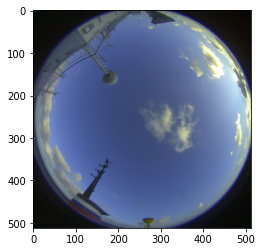

In [44]:
img = plt.imread("/content/train/img-2019-12-11T08-57-56devID1.jpg")
plt.imshow(img)
plt.show()

In [45]:
print(train.shape)
print(test.shape)
print(train.shape[0] + test.shape[0])
assert(data.shape[0] == train.shape[0] + test.shape[0])
print("OK!")

(64750, 2)
(27327, 2)
92077
OK!


In [46]:
class OceanDataset(Dataset) :
  def __init__(self, meta_data, root_dir, transforms = None):
      self.annotations = meta_data
      self.root_dir = root_dir
      self.transforms = transforms
  
  def __len__(self) :
      return len(self.annotations)
  
  def __getitem__(self, index) :
      img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
      image = io.imread(img_path)
      y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
      
      if self.transforms:
          image = self.transforms(image)
        
      
      return (image, y_label)

In [55]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [56]:
aug_color_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(512),
    torchvision.transforms.ColorJitter(hue=.06, saturation=.06),
    #torchvision.transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aug_flip_transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    #transforms.CenterCrop(512),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aug_noise_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 1.)
    #transforms.CenterCrop(512),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aug_crop_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(512),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    #torchvision.transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
aug_norm_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.CenterCrop(512),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    #torchvision.transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aug_transform = transforms.Compose([
  transforms.ToTensor(),
   torchvision.transforms.RandomHorizontalFlip(),
   transforms.CenterCrop(512),
   torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.CenterCrop(512),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.CenterCrop(224),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [57]:
#augmentation по экспедициям
ABP42_aug = OceanDataset(meta_data = ABP42_data_sets, root_dir = '/content/train/',
                       transforms  = aug_transform)
AI49_aug = OceanDataset(meta_data  = AI49_data_sets, root_dir = '/content/train/',
                       transforms  = aug_transform)
AI52_aug = OceanDataset(meta_data  = AI52_data_sets, root_dir = '/content/train/',
                       transforms  = aug_transform)
AMK79_aug = OceanDataset(meta_data = AMK79_data_sets, root_dir = '/content/train/',
                       transforms  = aug_transform)
ANS31_aug = OceanDataset(meta_data = ANS31_data_sets, root_dir = '/content/train/',
                       transforms  = aug_transform)

aug_norm_0class_transform = OceanDataset(meta_data = aug_0class, root_dir = '/content/train/',
                       transforms  = aug_norm_transform)
aug_crop_0class_transform = OceanDataset(meta_data = aug_0class, root_dir = '/content/train/',
                       transforms  = aug_crop_transform)
aug_flip_0class_transform = OceanDataset(meta_data = aug_0class, root_dir = '/content/train/',
                       transforms  = aug_flip_transform)
aug_color_0class_transform = OceanDataset(meta_data = aug_0class, root_dir = '/content/train/',
                       transforms  = aug_color_transform)
aug_noise_0class_transform = OceanDataset(meta_data = aug_0class, root_dir = '/content/train/',
                       transforms  = aug_noise_transform)

aug_norm_1class_transform = OceanDataset(meta_data = aug_1class, root_dir = '/content/train/',
                       transforms  = aug_norm_transform)
aug_crop_1class_transform = OceanDataset(meta_data = aug_1class, root_dir = '/content/train/',
                       transforms  = aug_crop_transform)
aug_flip_1class_transform = OceanDataset(meta_data = aug_1class, root_dir = '/content/train/',
                       transforms  = aug_flip_transform)
aug_color_1class_transform = OceanDataset(meta_data = aug_1class, root_dir = '/content/train/',
                       transforms  = aug_color_transform)
aug_noise_1class_transform = OceanDataset(meta_data = aug_1class, root_dir = '/content/train/',
                       transforms  = aug_noise_transform)

aug_norm_2class_transform = OceanDataset(meta_data = aug_2class, root_dir = '/content/train/',
                       transforms  = aug_norm_transform)
aug_crop_2class_transform = OceanDataset(meta_data = aug_2class, root_dir = '/content/train/',
                       transforms  = aug_crop_transform)
aug_flip_2class_transform = OceanDataset(meta_data = aug_2class, root_dir = '/content/train/',
                       transforms  = aug_flip_transform)
aug_color_2class_transform = OceanDataset(meta_data = aug_2class, root_dir = '/content/train/',
                       transforms  = aug_color_transform)
aug_noise_2class_transform = OceanDataset(meta_data = aug_2class, root_dir = '/content/train/',
                       transforms  = aug_noise_transform)

aug_norm_3class_transform = OceanDataset(meta_data = aug_3class, root_dir = '/content/train/',
                       transforms  = aug_norm_transform)
aug_crop_3class_transform = OceanDataset(meta_data = aug_3class, root_dir = '/content/train/',
                       transforms  = aug_crop_transform)
aug_flip_3class_transform = OceanDataset(meta_data = aug_3class, root_dir = '/content/train/',
                       transforms  = aug_flip_transform)
aug_color_3class_transform = OceanDataset(meta_data = aug_3class, root_dir = '/content/train/',
                       transforms  = aug_color_transform)
aug_noise_3class_transform = OceanDataset(meta_data = aug_3class, root_dir = '/content/train/',
                       transforms  = aug_noise_transform)

aug_norm_4class_transform = OceanDataset(meta_data = aug_4class, root_dir = '/content/train/',
                       transforms  = aug_norm_transform)
aug_crop_4class_transform = OceanDataset(meta_data = aug_4class, root_dir = '/content/train/',
                       transforms  = aug_crop_transform)
aug_flip_4class_transform = OceanDataset(meta_data = aug_4class, root_dir = '/content/train/',
                       transforms  = aug_flip_transform)
aug_color_4class_transform = OceanDataset(meta_data = aug_4class, root_dir = '/content/train/',
                       transforms  = aug_color_transform)
aug_noise_4class_transform = OceanDataset(meta_data = aug_4class, root_dir = '/content/train/',
                       transforms  = aug_noise_transform)


aug_norm_5class_transform = OceanDataset(meta_data = aug_5class, root_dir = '/content/train/',
                       transforms  = aug_norm_transform)
aug_crop_5class_transform = OceanDataset(meta_data = aug_5class, root_dir = '/content/train/',
                       transforms  = aug_crop_transform)
aug_flip_5class_transform = OceanDataset(meta_data = aug_5class, root_dir = '/content/train/',
                       transforms  = aug_flip_transform)
aug_color_5class_transform = OceanDataset(meta_data = aug_5class, root_dir = '/content/train/',
                       transforms  = aug_color_transform)
aug_noise_5class_transform = OceanDataset(meta_data = aug_5class, root_dir = '/content/train/',
                       transforms  = aug_noise_transform)


aug_norm_6class_transform = OceanDataset(meta_data = aug_6class, root_dir = '/content/train/',
                       transforms  = aug_norm_transform)
aug_crop_6class_transform = OceanDataset(meta_data = aug_6class, root_dir = '/content/train/',
                       transforms  = aug_crop_transform)
aug_flip_6class_transform = OceanDataset(meta_data = aug_6class, root_dir = '/content/train/',
                       transforms  = aug_flip_transform)
aug_color_6class_transform = OceanDataset(meta_data = aug_6class, root_dir = '/content/train/',
                       transforms  = aug_color_transform)
aug_noise_6class_transform = OceanDataset(meta_data = aug_6class, root_dir = '/content/train/',
                       transforms  = aug_noise_transform)

aug_norm_7class_transform = OceanDataset(meta_data = aug_7class, root_dir = '/content/train/',
                       transforms  = aug_norm_transform)
aug_crop_7class_transform = OceanDataset(meta_data = aug_7class, root_dir = '/content/train/',
                       transforms  = aug_crop_transform)
aug_flip_7class_transform = OceanDataset(meta_data = aug_7class, root_dir = '/content/train/',
                       transforms  = aug_flip_transform)
aug_color_7class_transform = OceanDataset(meta_data = aug_7class, root_dir = '/content/train/',
                       transforms  = aug_color_transform)
aug_noise_7class_transform = OceanDataset(meta_data = aug_7class, root_dir = '/content/train/',
                       transforms  = aug_noise_transform)

In [54]:
train_data = OceanDataset(meta_data = train, root_dir = '/content/train/',
                       transforms = train_transform)

In [59]:
train_set_class0 = torch.utils.data.ConcatDataset((train_data, aug_color_0class_transform))
train_set_class0 = torch.utils.data.ConcatDataset((train_set_class0, aug_noise_0class_transform))
train_set_class0 = torch.utils.data.ConcatDataset((train_set_class0, aug_flip_0class_transform))

train_set_class1 = torch.utils.data.ConcatDataset((train_set_class0, aug_color_1class_transform))
train_set_class1 = torch.utils.data.ConcatDataset((train_set_class1, aug_noise_1class_transform))
train_set_class1 = torch.utils.data.ConcatDataset((train_set_class1, aug_flip_1class_transform))
train_set_class1 = torch.utils.data.ConcatDataset((train_set_class1, aug_crop_1class_transform))

train_set_class2 = torch.utils.data.ConcatDataset((train_set_class1, aug_color_2class_transform))
train_set_class2 = torch.utils.data.ConcatDataset((train_set_class2, aug_noise_2class_transform))
train_set_class2 = torch.utils.data.ConcatDataset((train_set_class2, aug_flip_2class_transform))
train_set_class2 = torch.utils.data.ConcatDataset((train_set_class2, aug_crop_2class_transform))


train_set_class3 = torch.utils.data.ConcatDataset((train_set_class2, aug_color_3class_transform))
train_set_class3 = torch.utils.data.ConcatDataset((train_set_class3, aug_noise_3class_transform))
train_set_class3 = torch.utils.data.ConcatDataset((train_set_class3, aug_flip_3class_transform))
train_set_class3 = torch.utils.data.ConcatDataset((train_set_class3, aug_crop_3class_transform))

train_set_class4 = torch.utils.data.ConcatDataset((train_set_class3, aug_color_4class_transform))
train_set_class4 = torch.utils.data.ConcatDataset((train_set_class4, aug_noise_4class_transform))
train_set_class4 = torch.utils.data.ConcatDataset((train_set_class4, aug_flip_4class_transform))
train_set_class4 = torch.utils.data.ConcatDataset((train_set_class4, aug_crop_4class_transform))

train_set_class5 = torch.utils.data.ConcatDataset((train_set_class4, aug_color_5class_transform))
train_set_class5 = torch.utils.data.ConcatDataset((train_set_class5, aug_norm_5class_transform))
train_set_class5 = torch.utils.data.ConcatDataset((train_set_class5, aug_flip_5class_transform))
train_set_class5 = torch.utils.data.ConcatDataset((train_set_class5, aug_crop_5class_transform))
train_set_class5 = torch.utils.data.ConcatDataset((train_set_class5, aug_noise_5class_transform))

train_set_class6 = torch.utils.data.ConcatDataset((train_set_class5, aug_color_6class_transform))
train_set_class6 = torch.utils.data.ConcatDataset((train_set_class6, aug_noise_6class_transform))
train_set_class6 = torch.utils.data.ConcatDataset((train_set_class6, aug_flip_6class_transform))
train_set_class6 = torch.utils.data.ConcatDataset((train_set_class6, aug_crop_6class_transform))

train_set_class7 = torch.utils.data.ConcatDataset((train_set_class5, aug_color_6class_transform))
train_set_class7 = torch.utils.data.ConcatDataset((train_set_class6, aug_noise_6class_transform))
train_set_class7 = torch.utils.data.ConcatDataset((train_set_class6, aug_flip_6class_transform))

train_set = train_set_class7

print(len(train_data))
print(len(train_set))

64750
218087


In [60]:
train_set.__len__()

218087

In [61]:
test_set = OceanDataset(meta_data = test, root_dir = '/content/train/',
                       transforms = test_transform)

In [62]:
print(len(ABP42_data_sets))
print(len(AI49_data_sets))
print(len(AI52_data_sets))
print(len(AMK79_data_sets))
print(len(ANS31_data_sets))
print(len(ABP42_data_sets) + len(AI49_data_sets) + len(AI52_data_sets) + len(AMK79_data_sets) + len(ANS31_data_sets))

assert(len(ABP42_data_sets) == ABP42_aug.__len__())
assert(len(AI49_data_sets) == AI49_aug.__len__())
assert(len(AI52_data_sets) == AI52_aug.__len__())
assert(len(AMK79_data_sets) == AMK79_aug.__len__())
assert(len(ANS31_data_sets) == ANS31_aug.__len__())
assert((len(ABP42_data_sets) 
        + len(AI49_data_sets) 
        + len(AI52_data_sets)
        + len(AMK79_data_sets)
        + len(ANS31_data_sets))
        == len(train)
)
print("ok!")

28383
0
17142
13274
5951
64750
ok!


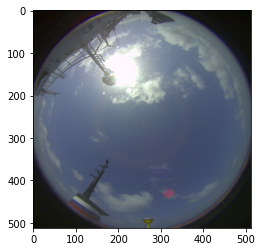

In [64]:
plt.imshow(train_set_class5[1][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


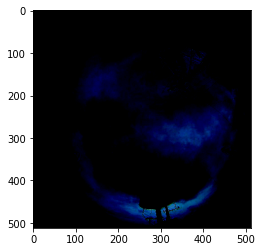

In [65]:
plt.imshow(ANS31_aug[1][0].permute(1, 2, 0))

In [66]:
train_loader = DataLoader(train_set_class5, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 16, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


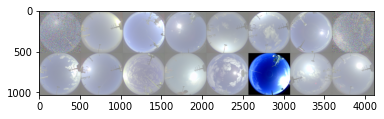

In [67]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)

images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels


## ResNet

In [73]:
from torchvision import datasets, transforms, models

In [74]:
model_Resnet = models.resnet50(pretrained=True)
model_Resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [75]:
import torch.nn as nn
from collections import OrderedDict

classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.LeakyReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=1024, out_features=512),
  nn.LeakyReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=512, out_features=9) 
)
    
model_Resnet.fc = classifier
model_Resnet.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=9, bias=True)
)

In [94]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Resnet.fc.parameters(), lr=0.01)
#optimizer = optim.SGD(model_Resnet.fc.parameters(), lr=0.01, momentum=0.9)
#gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_Resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [77]:
loss_history_train = []
epochs = 3

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()


    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        output = model_Resnet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        end_time = time.time()
        time_taken = end_time - start_time

        running_loss += loss.item()
        
        if i % 200 == 199: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            print('Time:',time_taken)
            loss_history_train.append(running_loss)
            running_loss = 0.0

print('Finished Training of ResNet')

[1,   200] loss: 2.086
Time: 151.55203557014465
[1,   400] loss: 1.983
Time: 303.87847566604614
[1,   600] loss: 1.824
Time: 454.08669686317444
[1,   800] loss: 1.668
Time: 605.3749120235443
[1,  1000] loss: 1.561
Time: 756.0045123100281
[1,  1200] loss: 1.497
Time: 908.1056380271912
[1,  1400] loss: 1.459
Time: 1059.7476539611816
[1,  1600] loss: 1.425
Time: 1211.6576347351074
[1,  1800] loss: 1.420
Time: 1365.2949407100677
[1,  2000] loss: 1.403
Time: 1514.9353303909302
[1,  2200] loss: 1.400
Time: 1666.1399393081665
[1,  2400] loss: 1.405
Time: 1815.9991116523743
[1,  2600] loss: 1.371
Time: 1967.621991634369
[1,  2800] loss: 1.385
Time: 2119.243225336075
[1,  3000] loss: 1.341
Time: 2268.679519891739
[1,  3200] loss: 1.382
Time: 2419.037875175476
[1,  3400] loss: 1.345
Time: 2569.6072840690613
[1,  3600] loss: 1.393
Time: 2717.0431830883026
[1,  3800] loss: 1.332
Time: 2866.116429567337
[1,  4000] loss: 1.363
Time: 3018.873771905899
[1,  4200] loss: 1.317
Time: 3170.960476875305
[1

KeyboardInterrupt: ignored

##Alex_Net

In [95]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [96]:
model.classifier[1] = torch.nn.Linear(9216, 4096)
model.classifier[4] = torch.nn.Linear(4096, 1024)
model.classifier[6] = torch.nn.Linear(1024, 9)

In [97]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [99]:
print(device)

cuda:0


In [100]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [102]:
criterion = torch.nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
loss_history_train = []
epochs = 1
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    start_time = time.time()

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        end_time = time.time()
        time_taken = end_time - start_time

        running_loss += loss.item()
        
        if i % 200 == 199: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            print('Time:',time_taken)
            loss_history_train.append(running_loss)
            running_loss = 0.0


print('Finished Training of AlexNet')

[1,   200] loss: 743.254
Time: 81.9954481124878
[1,   400] loss: 2.098
Time: 162.3304078578949
[1,   600] loss: 2.087
Time: 243.88910961151123
[1,   800] loss: 2.103
Time: 324.6888267993927


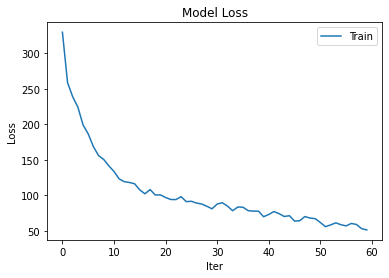

In [88]:
plt.plot(loss_history_train)
plt.title("Model Loss")
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.legend(['Train'])
plt.show()

In [93]:
correct = 0
total = 0

with torch.no_grad():
    for test_elem in test_loader:
        images, labels = test_elem[0].to(device), test_elem[1].to(device)
        predict_set = model(images)
        _, predicted = torch.max(predict_set.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total)

59.09540015369415


In [ ]:
correct = 0
total = 0
predict_set = None
with torch.no_grad():
    for test_elem in test_loader:
        images, labels = test_elem[0].to(device), test_elem[1].to(device)
        predict_set = model(images)
        _, predicted = torch.max(predict_set.data, 1) 

        total += labels.size(0)
        correct += (abs(labels - predicted) <= 1).sum().item()


print(100 * correct / total)

86.35781461558166


In [90]:
correct = 0
total = 0
predict_set = None
count = 0
with torch.no_grad():
    for test_elem in test_loader:
        images, labels = test_elem[0].to(device), test_elem[1].to(device)
        predict_set = model(images)
        _, predicted = torch.max(predict_set.data, 1)
        print(torch.max(predict_set.data, 1))
        print("--------")
        print(labels)
        print("\n")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if count == 2 :
            break
        count += 1


print(100 * correct / total)

torch.return_types.max(
values=tensor([10.5266,  7.9682,  2.1809,  8.4496,  5.5521, 12.2043,  9.3528,  9.3723,
         8.4260, 10.1691,  6.7215, 18.3354, 12.7662,  2.3990,  3.5590, 11.5196],
       device='cuda:0'),
indices=tensor([8, 0, 8, 5, 6, 8, 0, 8, 0, 8, 6, 8, 8, 8, 1, 8], device='cuda:0'))
--------
tensor([8, 0, 8, 8, 5, 8, 0, 8, 3, 8, 5, 8, 8, 7, 2, 8], device='cuda:0')


torch.return_types.max(
values=tensor([10.8126,  1.8499, 15.5516,  5.9738, 14.2184, 18.0953, 12.0523, 15.4791,
         9.0644, 16.0382, 15.0646, 14.1242,  2.3597,  5.1023, 18.4993, 17.3361],
       device='cuda:0'),
indices=tensor([8, 4, 8, 4, 8, 8, 8, 8, 7, 8, 0, 8, 5, 8, 8, 8], device='cuda:0'))
--------
tensor([8, 8, 8, 8, 8, 8, 7, 8, 6, 8, 0, 8, 4, 8, 8, 8], device='cuda:0')


torch.return_types.max(
values=tensor([16.2407, 14.5709,  5.9687, 13.1353, 17.0112, 15.4550,  7.1545, 16.5033,
         1.0124, 14.4962, 11.2277, 15.8936,  3.7603, 13.3024, 21.6858,  6.8729],
       device='cuda:0'),
indices=tenso

In [91]:
class_correct = list(0. for i in range(9))
class_total = list(0. for i in range(9))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_Resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()

        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(9):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 74 %
Accuracy of     1 : 36 %
Accuracy of     2 : 45 %
Accuracy of     3 : 27 %
Accuracy of     4 : 28 %
Accuracy of     5 : 13 %
Accuracy of     6 :  0 %
Accuracy of     7 :  2 %
Accuracy of     8 : 49 %
